In [119]:
#build xgboost regressor model
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_val_score, RandomizedSearchCV
import numpy as np 
import shap 
import matplotlib.pyplot as plt

In [120]:
# todo 
# create unit tests 
# use streamlit to make web app look nicer in main.py
# time series validation ? - look into this

In [121]:
data = pd.read_csv('combined_data_more.csv')

In [122]:
data.head()

,Year,Month,Day,Mean Temp (°C)
0,2011,1,1,5.7
1,2011,1,2,-2.1
2,2011,1,3,-3.1
3,2011,1,4,-1.8
4,2011,1,5,-5.9


In [123]:
data.isnull().sum()

Year              0
Month             0
Day               0
Mean Temp (°C)    0
dtype: int64

In [124]:
X = data[["Year", "Month", "Day"]]

In [125]:
y = data["Mean Temp (°C)"]

In [126]:
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data['day_of_year'] = data['date'].dt.dayofyear

In [127]:
mean_temp_per_day = data.groupby('day_of_year')['Mean Temp (°C)'].mean()

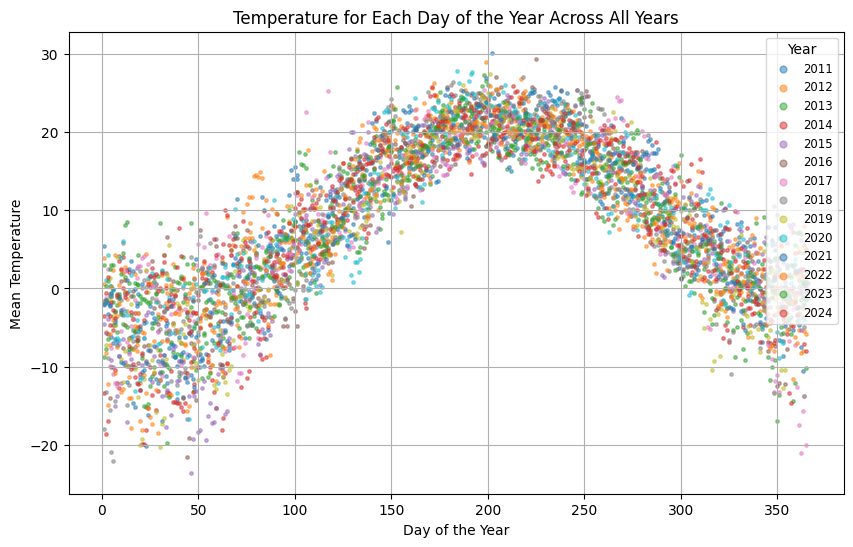

In [128]:
plt.figure(figsize=(10, 6))
for year in data['Year'].unique():
    yearly_data = data[data['Year'] == year]
    jitter = np.random.uniform(-0.4, 0.4, size=len(yearly_data))
    plt.scatter(yearly_data['day_of_year'], yearly_data['Mean Temp (°C)'] + jitter, label=year, alpha=0.5, s=6)

plt.title('Temperature for Each Day of the Year Across All Years')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Temperature')
plt.legend(title='Year', loc='upper right', fontsize='small', markerscale=2)
plt.grid(True)
plt.show()

In [129]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80, shuffle=True)

In [130]:
y_train.count

<bound method Series.count of 1279    18.1
3334    -4.7
2797    19.9
1235    14.1
2184     2.2
        ... 
2423    19.5
522     17.2
2259    -0.4
2982    -5.2
1199    10.5
Name: Mean Temp (°C), Length: 4091, dtype: float64>

In [131]:
y_test.count

<bound method Series.count of 4528    12.5
74       2.5
3148    19.1
195     19.6
2228    -2.3
        ... 
1340    19.9
2556   -19.9
3004     1.7
4905    20.3
1391    10.2
Name: Mean Temp (°C), Length: 1023, dtype: float64>

In [270]:
xgr = xgb.XGBRegressor(objective="reg:squarederror", subsample= 0.8, n_estimators= 1500, max_depth= 15, learning_rate= 0.3, eta= 0.3, colsample_bytree= 1.00)

In [271]:
xgr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [272]:
pred = xgr.predict(x_test)

In [273]:
mae = np.abs(mean_absolute_error(y_test, pred))
print("MAE : % f " %(mae))

MAE :  2.645218 


In [274]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [275]:
#{'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 15, 'learning_rate': 0.3, 'eta': 0.3, 'colsample_bytree': 1.0}
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 15,
    'eta': 0.3,
    'learning_rate': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 1.0
}

In [276]:
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')], early_stopping_rounds=100, verbose_eval=1)

[0]	test-rmse:7.60234
[1]	test-rmse:6.02045
[2]	test-rmse:5.00304
[3]	test-rmse:4.38349
[4]	test-rmse:4.02613
[5]	test-rmse:3.80971
[6]	test-rmse:3.67806
[7]	test-rmse:3.59045
[8]	test-rmse:3.54984
[9]	test-rmse:3.51572
[10]	test-rmse:3.48534
[11]	test-rmse:3.47900
[12]	test-rmse:3.46816
[13]	test-rmse:3.46440
[14]	test-rmse:3.46606
[15]	test-rmse:3.46438
[16]	test-rmse:3.46380
[17]	test-rmse:3.46195
[18]	test-rmse:3.46319
[19]	test-rmse:3.45647
[20]	test-rmse:3.45115
[21]	test-rmse:3.44908
[22]	test-rmse:3.44216
[23]	test-rmse:3.44488
[24]	test-rmse:3.44412
[25]	test-rmse:3.44223
[26]	test-rmse:3.44162
[27]	test-rmse:3.44245
[28]	test-rmse:3.44289
[29]	test-rmse:3.44076
[30]	test-rmse:3.44202
[31]	test-rmse:3.44048
[32]	test-rmse:3.44120
[33]	test-rmse:3.44074
[34]	test-rmse:3.44102
[35]	test-rmse:3.44046
[36]	test-rmse:3.44142
[37]	test-rmse:3.44047
[38]	test-rmse:3.44011
[39]	test-rmse:3.44064
[40]	test-rmse:3.44033
[41]	test-rmse:3.44020
[42]	test-rmse:3.43997
[43]	test-rmse:3.4408

In [277]:
pred2 = model.predict(dtest)

In [278]:
mae2 = np.abs(mean_absolute_error(y_test, pred2))
print("MAE : % f " %(mae2))

MAE :  2.645220 


In [279]:
#cross validation 
cv = RepeatedKFold(n_splits=12, n_repeats=3, random_state=1)

In [280]:
#evaluate model? 
scores = cross_val_score(xgr, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-2)

In [281]:
scores = np.absolute(scores)

In [282]:
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 2.477 (0.124)


In [213]:
# can find best parameters for model using parameter search
param_dist = {
    'max_depth': [8, 10, 12, 15],
    'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'n_estimators': [1000, 1500, 2000]
}
randomsearch = RandomizedSearchCV(
    estimator=xgr,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [214]:
randomsearch.fit(x_train, y_train)
print("Best Params: ", randomsearch.best_params_)
print("Best score: % f " % np.abs(randomsearch.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Params:  {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 15, 'learning_rate': 0.3, 'eta': 0.3, 'colsample_bytree': 1.0}
Best score:  2.794055 


In [147]:
#shap value stuff below

In [246]:
xgb_explainer = shap.Explainer(model, x_train)
shap_values = xgb_explainer(X)

 97%|=================== | 4976/5114 [00:40<00:01]       

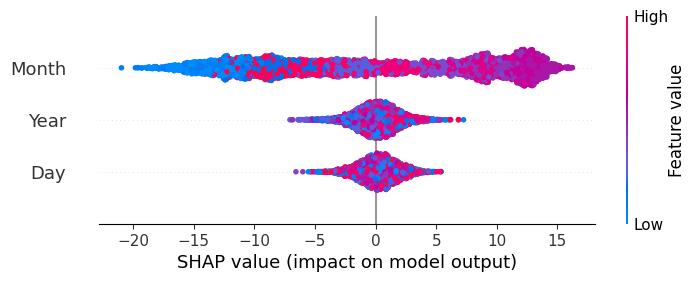

In [247]:
shap.plots.beeswarm(shap_values)

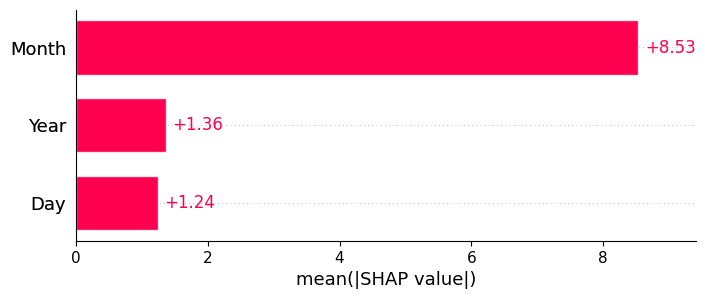

In [248]:
shap.plots.bar(shap_values)

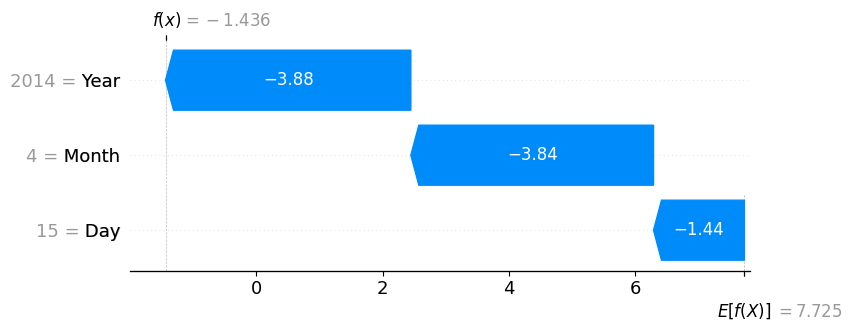

In [249]:
shap.plots.waterfall(shap_values[1200])

In [283]:
def predict_future_temp(year, month, day):
    future_date = pd.DataFrame({"Year": [year], "Month": [month], "Day": [day]})
    future_temp = model.predict(xgb.DMatrix(future_date))
    return future_temp[0]


In [284]:
predict_future_temp(2025, 3, 26) 

6.014543

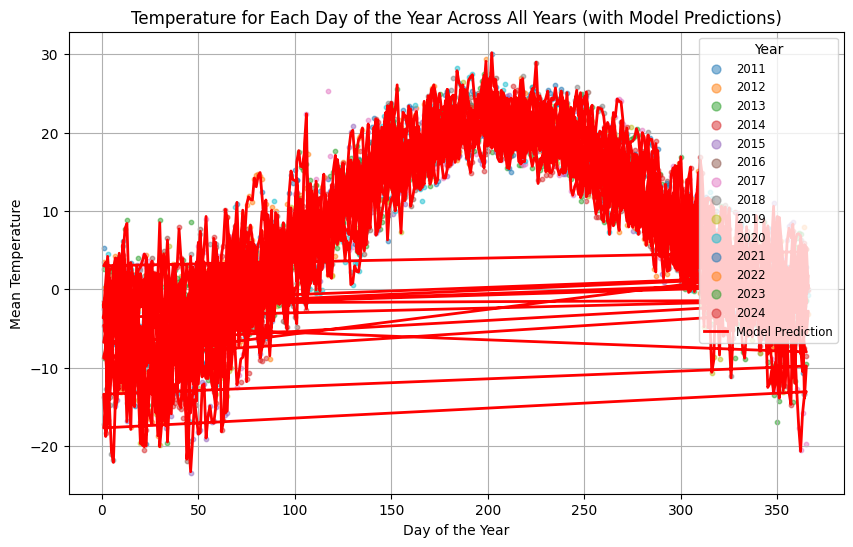

In [269]:
plt.figure(figsize=(10, 6))

# Scatter plot with jitter for each year
for i, year in enumerate(data['Year'].unique()):
    yearly_data = data[data['Year'] == year]
    jitter = np.random.uniform(-0.5, 0.5, size=len(yearly_data))  # Add small random noise
    plt.scatter(yearly_data['day_of_year'], yearly_data['Mean Temp (°C)'] + jitter, 
                label=year, alpha=0.5, s=10)

# Generate predictions for the training set
data['predicted_temp'] = data.apply(lambda row: predict_future_temp(row['Year'], row['Month'], row['Day']), axis=1)

# Plot the model's predictions as a line
plt.plot(data['day_of_year'], data['predicted_temp'], color='red', label='Model Prediction', linewidth=2)

plt.title('Temperature for Each Day of the Year Across All Years (with Model Predictions)')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Temperature')
plt.legend(title='Year', loc='upper right', fontsize='small', markerscale=2)
plt.grid(True)
plt.show()

In [285]:
model.save_model("xgboost_regressor_modelv2.json")